# **PR0404: Aplicación de patrones MapReduce**

## **Ejercicio 1: Limpieza y Transformación**

### **Patrón**

Filtrado y transformación.

### **Objetivo**

El dataset tiene años muy antiguos y valores nulos. Queremos un dataset limpio para años del siglo XXI.

### **Implementación**

**Mapper**:
- Lee línea por línea desde ``sys.stdin``.
- **Valida**: ignora cabeceras o líneas con errores de formato.
- **Filtra**: conserva solo registros donde ``year >= 2000`` y ``total_gdp > 0``.
- **Transforma**: emite solo ``Country Name``, ``Year`` y ``Total GDP``.
- **Salida**: imprime en STDOUT separado por tabuladores (``\t``).
  
**Reducer**:
- En este caso el reducer no tiene que hacer nada

In [1]:
%%writefile mapperpatrones1.py
#!/usr/bin/env python3
import os
import sys

for line in sys.stdin:
    partes = line.split(";")

    #Validar
    if len(partes) != 10:
        continue
    if partes[0] == "country_code":
        continue

    country_name = partes[4]
    year_texto = partes[6]
    total_gdp_texto = partes[7]

    #Transformar
    try:
        year = int(year_texto)
        total_gdp = float(total_gdp_texto)
    except:
        continue

    #Filtro y salida
    if year >= 2000 and total_gdp > 0:
        print(f"{country_name}\t{year}\t{total_gdp}")



Overwriting mapperpatrones1.py


In [2]:
!cat countries_gdp_hist.csv | python3 mapperpatrones1.py |head 

ARUBA	2000	1873452513.96648
ARUBA	2001	1896456983.24022
ARUBA	2002	1961843575.41899
ARUBA	2003	2044111731.84358
ARUBA	2004	2254830726.25698
ARUBA	2005	2360017318.43575
ARUBA	2006	2469782681.56425
ARUBA	2007	2677641340.78212
ARUBA	2008	2843024581.00559
ARUBA	2009	2553793296.08939
Traceback (most recent call last):
  File "/media/notebooks/mapperpatrones1.py", line 27, in <module>
    print(f"{country_name}\t{year}\t{total_gdp}")
BrokenPipeError: [Errno 32] Broken pipe
cat: write error: Broken pipe


In [20]:
!hadoop jar /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.4.0.jar \
-files mapperpatrones1.py \
-D mapreducer.job.reduces=0 \
-mapper "python3 mapperpatrones1.py" \
-input /countries_gdp_hist.csv \
-output /pr0404_1

packageJobJar: [/tmp/hadoop-unjar27417313054727393/] [] /tmp/streamjob5895301609292047954.jar tmpDir=null
2026-01-12 11:23:17,104 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.19.0.4:8032
2026-01-12 11:23:17,398 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at yarnmanager/172.19.0.4:8032
2026-01-12 11:23:18,149 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1768216716791_0001
2026-01-12 11:23:21,376 INFO mapred.FileInputFormat: Total input files to process : 1
2026-01-12 11:23:21,637 INFO mapreduce.JobSubmitter: number of splits:2
2026-01-12 11:23:21,915 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1768216716791_0001
2026-01-12 11:23:21,915 INFO mapreduce.JobSubmitter: Executing with tokens: []
2026-01-12 11:23:22,306 INFO conf.Configuration: resource-types.xml not found
2026-01-12 11:23:22,307 INFO resource.ResourceUtils: 

## **Ejercicio 2: Agregación por clave**

### **Patrón**

Resumen numérico (promedio).

### **Objetivo**

Calcular el PIB promedio histórico por cada Región (Asia, Americas, Europe…).

### **Implementación**

**1. Mapper**:
- Extrae ``region_name`` y ``total_gdp``.
- Emite: ``REGION \t GDP``

**2. Reducer**:
- Hadoop envía los datos ordenados por clave, hay que ir sumando los valores y el número de ocurrencias de la clave que llevamos. Cuando cambie la clave se emite el promedio de la región y se resetean contadores.

**3. Salida esperada**:
- ``AMERICAS 650000.50``, ``EUROPE 540000.20``, etc.

In [5]:
%%writefile mapperpatrones2.py
#!/usr/bin/env python3
import sys

for line in sys.stdin:
    partes = line.strip().split(";")
    if len(partes) != 10:
        continue
    if partes[0] == "country_code":
        continue

    region_name = partes[1]
    total_gdp_texto = partes[7]

    try:
        total_gdp = float(total_gdp_texto)
    except:
        continue

    print(f"{region_name}\t{total_gdp}")

Overwriting mapperpatrones2.py


In [6]:
%%writefile reducerpatrones2.py
#!/usr/bin/env python3
import sys

region_actual = None
suma_gdp = 0.0
contador = 0

for line in sys.stdin:
    line = line.strip()
    if not line:
        continue

    region, gdp_texto = line.split("\t")

    try:
        gdp = float(gdp_texto)
    except:
        continue

    if region == region_actual:
        suma_gdp = suma_gdp + gdp
        contador = contador + 1
    else:
        if region_actual is not None:
            promedio = suma_gdp / contador
            print(f"{region_actual}\t{promedio:.2f}")

        region_actual = region
        suma_gdp = gdp
        contador = 1

#Imprimir la última región
if region_actual is not None:
    promedio = suma_gdp / contador
    print(f"{region_actual}\t{promedio:.2f}")

Overwriting reducerpatrones2.py


In [7]:
!cat countries_gdp_hist.csv | python3 mapperpatrones2.py | sort | python3 reducerpatrones2.py

AFRICA	17415301365.06
AMERICAS	250120768754.78
ASIA	205913293760.72
EUROPE	213179096872.72
OCEANIA	32533011434.88


## **Ejercicio 3: Máximos por grupo (Filtering/Top-K)**

### **Patrón**

Top-K per Group.

### **Objetivo**

Encontrar el año de mayor variación de PIB (``gdp_variation``) para cada país.

### **Implementación**

**1. Mapper**:
- Emite: ``Country_Name \t Year,Variation`` (Concatena año y variación en el valor para no perder el dato del año).

**2. Reducer**:
- Para cada país, recorre todas las variaciones.
- Mantén en memoria solo la variación más alta encontrada hasta el momento y su año asociado.
- Al cambiar de país, emite: ``PAIS \t AÑO_RECORD (VARIACION)``

In [8]:
%%writefile mapperpatrones3.py
#!/usr/bin/env python3
import sys

for line in sys.stdin:
    partes = line.strip().split(";")
    if len(partes) != 10:
        continue
    if partes[0] == "country_code":
        continue

    pais = partes[4]
    year_texto = partes[6]
    variacion_texto = partes[9]

    try:
        year = int(year_texto)
        variacion = float(variacion_texto)
    except:
        continue

    print(f"{pais}\t{year}\t{variacion}")

Overwriting mapperpatrones3.py


In [13]:
%%writefile reducerpatrones3.py
#!/usr/bin/env python3
import sys

pais_actual = ""
mejor_year = 0
mejor_variacion = -999999999  

for line in sys.stdin:
    pais, year_texto, variacion_texto = line.strip().split("\t")

    year = int(year_texto)
    variacion = float(variacion_texto)

    # Si es el primer país o ha cambiado el país
    if pais_actual != "" and pais != pais_actual:
        print(f"{pais_actual}\t{mejor_year} ({mejor_variacion:.2f})")
        mejor_variacion = -999999999  
        mejor_year = 0

    # Si esta variación es mejor que la guardada, la actualizo
    if variacion > mejor_variacion:
        mejor_variacion = variacion
        mejor_year = year

    pais_actual = pais

if pais_actual != "":
    print(f"{pais_actual}\t{mejor_year} ({mejor_variacion:.2f})")


Overwriting reducerpatrones3.py


In [37]:
!cat countries_gdp_hist.csv | python3 mapperpatrones3.py | sort | python3 reducerpatrones3.py

AFGHANISTAN	2002 (28.60)
ALBANIA	1995 (13.32)
ALGERIA	1963 (34.31)
AMERICAN SAMOA	2020 (4.41)
ANDORRA	2022 (9.56)
ANGOLA	2005 (15.03)
ANTIGUA AND BARBUDA	2006 (12.71)
ARGENTINA	1965 (10.57)
ARMENIA	2003 (14.00)
ARUBA	2021 (24.13)
AUSTRALIA	1970 (7.18)
AUSTRIA	1970 (7.12)
AZERBAIJAN	2006 (34.50)
BAHAMAS	1979 (26.14)
BAHRAIN	1976 (30.48)
BANGLADESH	1964 (10.95)
BARBADOS	2022 (17.83)
BELARUS	2004 (11.45)
BELGIUM	1964 (6.96)
BELIZE	2021 (17.75)
BENIN	1981 (9.95)
BERMUDA	1966 (14.36)
BHUTAN	1987 (29.05)
BOLIVIA (PLURINATIONAL STATE OF)	1968 (8.53)
BOSNIA AND HERZEGOVINA	1996 (54.20)
BOTSWANA	1972 (26.36)
BRAZIL	1973 (13.97)
BRUNEI DARUSSALAM	1979 (24.34)
BULGARIA	1988 (10.94)
BURKINA FASO	1996 (11.01)
BURUNDI	1970 (21.33)
CABO VERDE	1994 (19.18)
CAMBODIA	1987 (21.53)
CAMEROON	1978 (22.00)
CANADA	1962 (7.43)
CAYMAN ISLANDS	2022 (5.16)
CENTRAL AFRICAN REPUBLIC	1984 (9.48)
CHAD	2004 (33.63)
CHILE	2021 (11.33)
CHINA	1970 (19.30)
COLOMBIA	2021 (10.80)
COMOROS	2000 (10.85)
CONGO	1982 (23.60)
CONG

## **Ejercicio 4: Join (Reduce-Side Join)**

### **Patrón** 

Reduce-Side Join.

### **Objetivo**

Unir el dataset de PIB con un dataset auxiliar de códigos de país para obtener el nombre completo en español (simulado).

### **Implementación**

**1. Datos Auxiliares**: necesitas un fichero que relacione los códigos de los países con su respectivo nombre. Puedes utilizar este dataset disponible en Github.

**2. Estrategia**:
- Subir ambos archivos (``gdp.csv`` y ``codes.csv``) a HDFS.
- **Mapper**

Debe detectar qué archivo está leyendo. Una forma de hacerlo sería contando la cantidad de columnas del fichero. Ten cuidado, porque en un fichero el separador es el punto y coma, mientras que en el otro es la coma, así que lo que puedes hacer es:
  
  Separo por comas, si obtengo ``X`` campos es el fichero ``codes.csv``
  
  Si no, separo por punto y coma, y compruebo que el número de campos concuerda con el fichero ``gdp.csv``

Si es ``codes.csv``: Emite ``CODIGO \t A_NombreEsp`` (Tag ‘A’, que usaré en el reducer para distinguir entre uno y otro).

Si es ``gdp.csv``: Emite ``CODIGO \t B_PIB`` (Tag ‘B’).

- **Reducer**
        Recibirá todas las líneas de un mismo código juntas (ej. ``ESP``).
        Guarda el nombre en español (Tag A) en una variable.
        Cuando lleguen los datos del PIB (Tag B), imprime: ``Nombre_Español \t PIB.

**3. Ejecución**: ten en cuenta que, en este caso, el mapper recibirá dos ficheros, por lo que habría que invocarlo de la siguiente forma (observa que hay dos ``-input``):
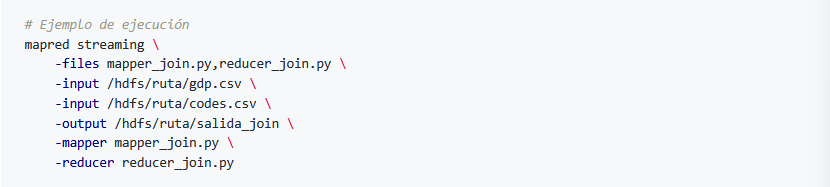join.py

In [18]:
%%writefile mapperpatrones4.py
#!/usr/bin/env python3
import sys

for line in sys.stdin:
    line = line.strip()
    if not line:
        continue

    # ---------- CODES.CSV (coma) ----------
    if "," in line and ";" not in line:
        partes = line.split(",")
        if len(partes) < 3:
            continue

        if partes[0] == "name":
            continue

        nombre_pais = partes[0]
        codigo_alpha3 = partes[2]   #CLAVE DEL JOIN

        print(f"{codigo_alpha3}\tA|{nombre_pais}")
        continue

    # ---------- GDP.CSV (punto y coma) ----------
    if ";" in line:
        partes = line.split(";")
        if len(partes) != 10:
            continue
        if partes[0] == "country_code":
            continue

        codigo = partes[0]          # ESP, FRA...
        pib_millones = partes[8]    # total_gdp_million

        if pib_millones == "":
            continue

        print(f"{codigo}\tB|{pib_millones}")


Overwriting mapperpatrones4.py


In [19]:
%%writefile reducerpatrones4.py
#!/usr/bin/env python3
import sys

codigo_actual = None
nombre_pais = None

for line in sys.stdin:
    codigo, valor = line.strip().split("\t", 1)

    if codigo != codigo_actual and codigo_actual is not None:
        nombre_pais = None

    codigo_actual = codigo

    if valor.startswith("A|"):
        nombre_pais = valor[2:]
    elif valor.startswith("B|") and nombre_pais is not None:
        print(f"{nombre_pais}\t{valor[2:]}")


Overwriting reducerpatrones4.py


In [21]:
!cat all.csv countries_gdp_hist.csv | python3 mapperpatrones4.py | sort | python3 reducerpatrones4.py | tail -100 

cat: all.csv: No such file or directory


In [22]:
!hadoop jar /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.4.0.jar \

-files mapperpatrones4.py,reducerpatrones4.py \
-mapper mapperpatrones4.py \
-reducer reducerpatrones4.py \
-input ../all.csv \
-input ../countries_gdp_hist.csv \
-output ../salida_join \

SyntaxError: invalid syntax (665659067.py, line 2)

## **Ejercicio 5: Distribución de Riqueza (Binning Pattern)**

### **Patrón**

Binning (Categorización en cubos).

### **Objetivo**

Clasificar los registros en rangos de riqueza definidos manualmente para generar un histograma. En lugar de agrupar por una columna existente (como Región), debes crear tu propia clave de agrupación basada en lógica de negocio.

Queremos saber cuántos registros de la historia corresponden a economías “Pequeñas”, “Medianas” y “Grandes” basándonos en el ``total_gdp_million``.

Las **reglas de negocio (bins)** son:

- **Economía Pequeña:** GDP < 10,000 Millones.
- **Economía Mediana:** 10,000 <= GDP < 1,000,000 Millones.
- **Economía Grande:** GDP >= 1,000,000 Millones.

### **Implementación**

1. Mapper

- Leer ``total_gdp_million``.
- Determinar la categoría según las reglas de negocio.
- **Salida**: ``CATEGORIA \t 1`` (Emitimos un 1 para contar).

2. **Reducer**

- Suma simple de los “1” recibidos por cada categoría.
- **Salida esperada**:
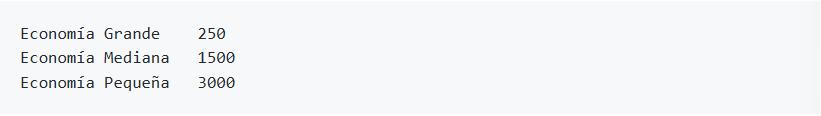

In [23]:
%%writefile mapperpatrones5.py
#!/usr/bin/env python3
import sys

for line in sys.stdin:
    partes = line.strip().split(";")

    if len(partes) != 10:
        continue
    if partes[0] == "country_code":
        continue

    gdp_million_texto = partes[8]

    try:
        gdp_million = float(gdp_million_texto)
    except:
        continue

    if gdp_million < 10000:
        categoria = "Economia Pequena"
    elif 10000 <= gdp_million < 1000000:
        categoria = "Economia Mediana"
    else:
        categoria = "Economia Grande"

    print(f"{categoria}\t1")


Overwriting mapperpatrones5.py


In [24]:
%%writefile reducerpatrones5.py
#!/usr/bin/env python3
import sys

categoria_actual = None
contador = 0

for line in sys.stdin:
    categoria, valor = line.strip().split("\t")
    valor = int(valor)

    if categoria == categoria_actual:
        contador += valor
    else:
        if categoria_actual is not None:
            print(f"{categoria_actual}\t{contador}")
        categoria_actual = categoria
        contador = valor

if categoria_actual is not None:
    print(f"{categoria_actual}\t{contador}")


Overwriting reducerpatrones5.py


In [25]:
!cat countries_gdp_hist.csv | python3 mapperpatrones5.py | sort | python3 reducerpatrones5.py

Economia Grande	423
Economia Mediana	4777
Economia Pequena	8560


In [26]:
%%writefile mapperpatrones6.py
#!/usr/bin/env python3
import sys

for line in sys.stdin:
    partes = line.strip().split(";")

    if len(partes) != 10:
        continue
    if partes[0] == "country_code":
        continue

    country_name = partes[4]
    income_group = partes[5]

    print(f"{income_group}\t{country_name}")


Overwriting mapperpatrones6.py


In [27]:
%%writefile reducerpatrones6.py
#!/usr/bin/env python3
import sys

grupo_actual = None
paises = set()

for line in sys.stdin:
    grupo, pais = line.strip().split("\t")

    if grupo == grupo_actual:
        paises.add(pais)
    else:
        if grupo_actual is not None:
            lista = ", ".join(sorted(paises))
            print(f"{grupo_actual}\t{lista}")

        grupo_actual = grupo
        paises = set()
        paises.add(pais)

if grupo_actual is not None:
    lista = ", ".join(sorted(paises))
    print(f"{grupo_actual}\t{lista}")


Overwriting reducerpatrones6.py


In [28]:
!cat countries_gdp_hist.csv | python3 mapperpatrones6.py | sort | python3 reducerpatrones6.py

INGRESO ALTO	AMERICAN SAMOA, ANDORRA, ANTIGUA AND BARBUDA, ARUBA, AUSTRALIA, AUSTRIA, BAHAMAS, BAHRAIN, BARBADOS, BELGIUM, BERMUDA, BRUNEI DARUSSALAM, BULGARIA, CANADA, CAYMAN ISLANDS, CHILE, CROATIA, CURAÇAO, CYPRUS, CZECHIA, DENMARK, ESTONIA, FAROE ISLANDS, FINLAND, FRANCE, FRENCH POLYNESIA, GERMANY, GIBRALTAR, GREECE, GREENLAND, GUAM, GUYANA, HONG KONG, HUNGARY, ICELAND, IRELAND, ISLE OF MAN, ISRAEL, ITALY, JAPAN, KOREA, REPUBLIC OF, KUWAIT, LATVIA, LIECHTENSTEIN, LITHUANIA, LUXEMBOURG, MACAO, MALTA, MONACO, NAURU, NETHERLANDS, NEW CALEDONIA, NEW ZEALAND, NORTHERN MARIANA ISLANDS, NORWAY, OMAN, PALAU, PANAMA, POLAND, PORTUGAL, PUERTO RICO, QATAR, ROMANIA, RUSSIAN FEDERATION, SAINT KITTS AND NEVIS, SAINT MARTIN (FRENCH PART), SAN MARINO, SAUDI ARABIA, SEYCHELLES, SINGAPORE, SINT MAARTEN (DUTCH PART), SLOVAKIA, SLOVENIA, SPAIN, SWEDEN, SWITZERLAND, TRINIDAD AND TOBAGO, TURKS AND CAICOS ISLANDS, UNITED ARAB EMIRATES, UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND, UNITED STATES O